The detaild Description and the mathematics behind each of the follwing cryptographic functions can be found in the report accompaning this jupyter notebook.

# **Hash Functions**
We will implement a code for the SHA-256, below is using the hashlib module.

In [1]:
import hashlib

def calculate_sha256_string(text):
    """Calculate SHA-256 hash of a string."""
    sha256_hash = hashlib.sha256()
    sha256_hash.update(text.encode('utf-8'))
    return sha256_hash.hexdigest()


text = "Hello, World!"
hash_result = calculate_sha256_string(text)
print(f"SHA-256 hash of '{text}': {hash_result}")

SHA-256 hash of 'Hello, World!': dffd6021bb2bd5b0af676290809ec3a53191dd81c7f70a4b28688a362182986f


# **Diﬃe-Hellman**

In [3]:
!pip install pycryptodome

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 31.7 MB/s eta 0:00:00


In [7]:
import random
import hashlib
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
import os

def is_prime(n, k=5):
    """Miller-Rabin primality test"""
    if n <= 1:
        return False
    elif n <= 3:
        return True
    elif n % 2 == 0:
        return False

    # Write n as d*2^s + 1
    d = n - 1
    s = 0
    while d % 2 == 0:
        d //= 2
        s += 1

    for _ in range(k):
        a = random.randint(2, n - 2)
        x = pow(a, d, n)
        if x == 1 or x == n - 1:
            continue
        for __ in range(s - 1):
            x = pow(x, 2, n)
            if x == n - 1:
                break
        else:
            return False
    return True

def generate_large_prime(bits=1024):
    """Generate a large prime number"""
    while True:
        p = random.getrandbits(bits)
        p |= (1 << bits - 1) | 1  # Set MSB and LSB to ensure size and oddness
        if is_prime(p):
            return p

def generate_primitive_root(p):
    """Find a primitive root modulo p"""
    if p == 2:
        return 1
    # Factorize p-1
    phi = p - 1
    factors = set()
    n = phi
    for i in [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31]:
        while n % i == 0:
            factors.add(i)
            n = n // i
    # Test for primitive roots
    for g in range(2, p):
        flag = True
        for factor in factors:
            if pow(g, phi // factor, p) == 1:
                flag = False
                break
        if flag:
            return g
    return None

def diffie_hellman_key_exchange():
    """Perform DH key exchange and return shared key"""
    # Generate a large prime p and primitive root g
    p = generate_large_prime(512)  # Using 512-bit prime for example
    g = generate_primitive_root(p)

    # Alice's private key
    a_private = random.randint(2, p - 2)
    # Alice's public key
    A = pow(g, a_private, p)

    # Bob's private key
    b_private = random.randint(2, p - 2)
    # Bob's public key
    B = pow(g, b_private, p)

    # Shared secret
    alice_shared = pow(B, a_private, p)
    bob_shared = pow(A, b_private, p)
    assert alice_shared == bob_shared

    # Derive AES key from shared secret
    shared_key = hashlib.sha256(str(alice_shared).encode()).digest()
    return shared_key

def encrypt(message, key):
    """Encrypt message using AES-CBC"""
    iv = os.urandom(16)
    cipher = AES.new(key, AES.MODE_CBC, iv)
    ciphertext = cipher.encrypt(pad(message.encode(), AES.block_size))
    return iv + ciphertext

def decrypt(ciphertext, key):
    """Decrypt message using AES-CBC"""
    iv = ciphertext[:16]
    cipher = AES.new(key, AES.MODE_CBC, iv)
    plaintext = unpad(cipher.decrypt(ciphertext[16:]), AES.block_size)
    return plaintext.decode()


if __name__ == "__main__":

    shared_key = diffie_hellman_key_exchange()
    print("Shared AES Key:", shared_key.hex())


    message = "Hello, World!"
    print("Original Message:", message)

    ciphertext = encrypt(message, shared_key)
    print("Encrypted Message:", ciphertext.hex())


    decrypted = decrypt(ciphertext, shared_key)
    print("Decrypted Message:", decrypted)

Shared AES Key: f89687ecea60b6c0a423ae6b9277dde5b9919c91e71516896f50609f2e6582d2
Original Message: Hello, World!
Encrypted Message: 2038ae78a237f40599922973bfa64f58ae2d1dc87a04e53bc83acd67b364994c
Decrypted Message: Hello, World!


# **Elliptic Curves**

Plotting an elliptic curve for a small prime field.

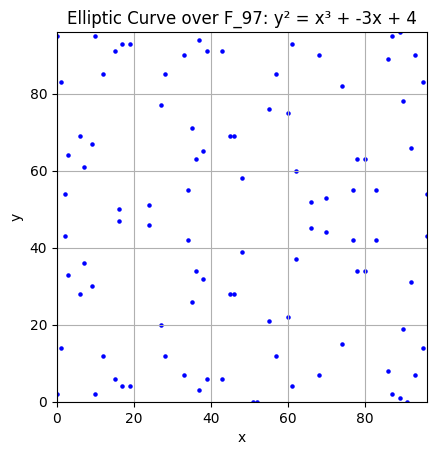

In [10]:
import matplotlib.pyplot as plt

def plot_elliptic_curve_finite_field(p, a, b):
    """Plots elliptic curve y² ≡ x³ + ax + b (mod p) over a finite field."""
    points = []
    for x in range(p):
        rhs = (x**3 + a * x + b) % p
        for y in range(p):
            if (y * y) % p == rhs:
                points.append((x, y))

    if points:
        x_vals, y_vals = zip(*points)
        plt.scatter(x_vals, y_vals, color='blue', s=5)
        plt.title(f"Elliptic Curve over F_{p}: y² = x³ + {a}x + {b}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.grid(True)
        plt.xlim(0, p - 1)
        plt.ylim(0, p - 1)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()
    else:
        print("No points found on the curve!")


p_small = 97
a_small = -3
b_small = 4
plot_elliptic_curve_finite_field(p_small, a_small, b_small)

The same elliptic curve over the reals is a smooth curve

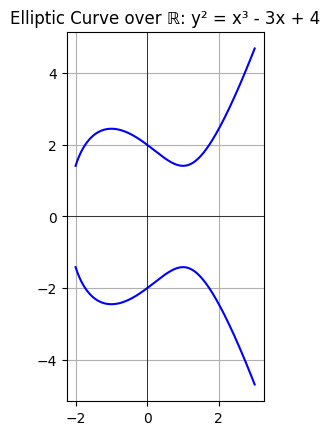

In [11]:
import numpy as np
import matplotlib.pyplot as plt


x = np.linspace(-2, 3, 500)
y_squared = x**3 - 3*x + 4
y_pos = np.sqrt(np.maximum(y_squared, 0))
y_neg = -y_pos

plt.plot(x, y_pos, 'b')
plt.plot(x, y_neg, 'b')
plt.title("Elliptic Curve over ℝ: y² = x³ - 3x + 4")
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.gca().set_aspect('equal')
plt.show()

# **Digital Signatures**
Below is an implementation of ECDSA(used by Bitcoin), but using the NIST256p curve

In [8]:
!pip install ecdsa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 7.4 MB/s eta 0:00:00


In [12]:
from ecdsa import SigningKey, NIST256p
import hashlib

def generate_keys():
    """Generate ECDSA key pair"""
    private_key = SigningKey.generate(curve=NIST256p)
    public_key = private_key.get_verifying_key()
    return private_key, public_key

def sign_message(private_key, message):
    """Sign a message with private key"""
    # Hash the message first (common practice)
    message_hash = hashlib.sha256(message.encode()).digest()
    signature = private_key.sign(message_hash)
    return signature

def verify_signature(public_key, message, signature):
    """Verify a signature with public key"""
    try:
        message_hash = hashlib.sha256(message.encode()).digest()
        return public_key.verify(signature, message_hash)
    except:
        return False


if __name__ == "__main__":

    private_key, public_key = generate_keys()
    print(f"Private key (hex): {private_key.to_string().hex()}")
    print(f"Public key (hex): {public_key.to_string().hex()}")


    message = "This is a test transaction for blockchain"
    signature = sign_message(private_key, message)
    print(f"Signature (hex): {signature.hex()}")


    is_valid = verify_signature(public_key, message, signature)
    print(f"Signature valid: {is_valid}")

    tampered_message = message + " "
    is_valid_tampered = verify_signature(public_key, tampered_message, signature)
    print(f"Tampered message valid: {is_valid_tampered}")

Private key (hex): b47de101296b043129b0df2d374ab8d5092d5f9aaaea380e93796423aac9de1e
Public key (hex): 63ff9ffb6b47296f7324b3381c28a425b76882020af5f2e4d8e41d9e418f7f4506e7000eea9578c265bafb970d78c19219b4cb2009894e17fc73480c986ad700
Signature (hex): 73db10593df5363d3812adfa1087a8a95940b742f073e701a50ccb97f0aebd5ef649c0ed5c7442756847856362b6f0715a678899921db56f1d03803715d37bf4
Signature valid: True
Tampered message valid: False


# **Merkle Trees**

In [13]:
import hashlib
from typing import List, Optional

class MerkleTree:
    def __init__(self, data: List[bytes]):
        """Initialize Merkle Tree with list of data items"""
        if not data:
            raise ValueError("Empty data list")

        self.leaves = [self._hash(item) for item in data]
        self.tree = self.build_tree(self.leaves)

    @staticmethod
    def _hash(data: bytes) -> bytes:
        """Double SHA-256 hash (Bitcoin standard)"""
        return hashlib.sha256(hashlib.sha256(data).digest()).digest()

    def build_tree(self, leaves: List[bytes]) -> List[List[bytes]]:
        """Build the Merkle tree from leaves"""
        tree = [leaves]
        current_level = leaves

        while len(current_level) > 1:
            next_level = []

            # Pair up nodes and hash them together
            for i in range(0, len(current_level), 2):
                left = current_level[i]
                right = current_level[i+1] if i+1 < len(current_level) else left
                combined = left + right
                next_level.append(self._hash(combined))

            tree.append(next_level)
            current_level = next_level

        return tree

    def get_root(self) -> bytes:
        """Get the Merkle root hash"""
        return self.tree[-1][0]

    def get_proof(self, index: int) -> List[bytes]:
        """Get the Merkle proof for a leaf at given index"""
        if index >= len(self.leaves):
            raise IndexError("Leaf index out of range")

        proof = []
        current_index = index

        for level in self.tree[:-1]:
            # Determine if current node is left or right in pair
            pair_index = current_index + 1 if current_index % 2 == 0 else current_index - 1
            if pair_index < len(level):
                proof.append(level[pair_index])
            current_index = current_index // 2

        return proof

    @staticmethod
    def verify_proof(root: bytes, leaf: bytes, proof: List[bytes], index: int) -> bool:
        """Verify a Merkle proof against known root"""
        current_hash = leaf

        for i, sibling in enumerate(proof):
            # Determine if proof element is left or right sibling
            if index // (2 ** i) % 2 == 0:
                combined = current_hash + sibling
            else:
                combined = sibling + current_hash
            current_hash = hashlib.sha256(hashlib.sha256(combined).digest()).digest()

        return current_hash == root


# Example Usage
if __name__ == "__main__":
    # Sample data (convert strings to bytes)
    data = [f"tx{i}".encode() for i in range(1, 5)]
    print("Original data:", [d.decode() for d in data])

    # Build Merkle Tree
    merkle_tree = MerkleTree(data)
    print("Merkle Root:", merkle_tree.get_root().hex())

    # Get and verify proof for first transaction
    proof = merkle_tree.get_proof(0)
    print("Proof for tx1:", [p.hex() for p in proof])

    is_valid = MerkleTree.verify_proof(
        merkle_tree.get_root(),
        merkle_tree.leaves[0],
        proof,
        0
    )
    print("Proof valid:", is_valid)

    # Test with invalid data
    fake_data = "fake_tx".encode()
    is_valid_fake = MerkleTree.verify_proof(
        merkle_tree.get_root(),
        fake_data,
        proof,
        0
    )
    print("Proof with fake data:", is_valid_fake)

Original data: ['tx1', 'tx2', 'tx3', 'tx4']
Merkle Root: ef58d462072a7f0af6b80212ef874a82fde181959e0116d1e5b325d980b6c6ae
Proof for tx1: ['79043a4d1d4d6d0b830519bfc07b92b4d162a4cd54235719c2c3cc211a638dfd', '2b96a3274331a359d5afbcfd22cb36cd30fdc2306d9bc9c172b399635841a423']
Proof valid: True
Proof with fake data: False
